In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We get the helper Python file and the files containing the training and validation data.

In [ ]:
!rm -f *py *tsv
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py
#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/train.tsv
#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/devel.tsv

# If you have trouble downloading from github, instead get them from 
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/train.tsv
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/devel.tsv


--2022-12-09 14:52:14--  http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25178 (25K) [text/plain]
Saving to: ‘ner_util.py’

ner_util.py         100%[===================>]  24.59K  28.3KB/s    in 0.9s    

2022-12-09 14:52:15 (28.3 KB/s) - ‘ner_util.py’ saved [25178/25178]

--2022-12-09 14:52:15--  http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/train.tsv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1039940 (1016K) [text/tab-separated-values]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]   1016K  12.6KB/s    in 44s     

2022-12-09 14:52:59 (23.3 KB/s) - ‘train.

The infrastructure code (vocabulary management, training loop, word embedding loading, evaluation, etc) has been moved into a separate file <code>ner_util.py</code> you can get [here](http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py). Download this file and put it into the same directory as where you are executing your notebook. Import this file and you are ready to go.

In [ ]:
import ner_util

## Reading the data in a tabular format

The following function reads a file represented in a tabular format. In this format, each row corresponds to one token. For each token, there is a word and the BIO-coded named entity label, separated by whitespace. The sentences are separated by empty lines. Here is an example of a sentence.
```
In              O
conclusion      O
,               O
hyperammonemic  B-Disease
encephalopathy  I-Disease
can             O
occur           O
in              O
patients        O
receiving       O
continuous      O
infusion        O
of              O
5               B-Chemical
-               I-Chemical
FU              I-Chemical
.               O
```
The function `ner_util.read_data` reads the file in this format and returns sentences and their corresponding BIO labels.

In [ ]:
Xtrain, Ytrain = ner_util.read_data('train.tsv')
Xval, Yval = ner_util.read_data('devel.tsv')

An example:

In [ ]:
Xtrain[100]

['High',
 'doses',
 'of',
 'vitamin',
 'D',
 'are',
 'known',
 'to',
 'cause',
 'calcification',
 'of',
 'the',
 'artery',
 'media',
 'in',
 'as',
 'little',
 'as',
 '3',
 'to',
 '4',
 'days',
 '.']

In [ ]:
Ytrain[100]

['O',
 'O',
 'O',
 'B-Chemical',
 'I-Chemical',
 'O',
 'O',
 'O',
 'O',
 'B-Disease',
 'I-Disease',
 'I-Disease',
 'I-Disease',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

## Baseline sequence labeling model

This is the baseline model. You can expand on this when implementing your solution.

In [ ]:
import torch
from torch import nn

class BaselineSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.        
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        
        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]

        #input
        self.rnn = nn.GRU(input_size = word_emb_dim, hidden_size = p.hidden_size, num_layers = p.n_layers,
                          batch_first = p.batch_first, dropout = p.word_dropout_prob, bidirectional = p.bidirectional)
        
        # Output unit.
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
                        
    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)      
        batch_size, max_sen_length = words.shape  

        # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim). 
        word_repr = self.word_embedding(words)
        #print(word_repr.shape)
        #print(words.shape)
        out, hidden = self.rnn(word_repr)
        #print(out.shape)
        #out = out.contiguous().view(-1, hidden.shape[-1])
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        out = self.top_layer(out)
        
        return out 

## Training the system

As usual, we create an object that contains all hyperparameters.

In [ ]:
class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 1234
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128

    # Add som GRU params
    hidden_size = 64
    n_layers = 2
    batch_first = True
    bidirectional = True
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = True

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False

Now, we are ready to train. When creating the NER system, the first argument should be the hyperparameter container. The second should be a function that builds the neural network; we just use the constructor of the class we defined above.

In [ ]:

ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)

ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 0.3634, val f1: 0.4538, time = 1.2855
Epoch 2: train loss = 0.1516, val f1: 0.5668, time = 0.9131
Epoch 3: train loss = 0.0787, val f1: 0.5850, time = 0.9215
Epoch 4: train loss = 0.0423, val f1: 0.5704, time = 0.9246
Epoch 5: train loss = 0.0233, val f1: 0.5797, time = 0.9269
Epoch 6: train loss = 0.0172, val f1: 0.5847, time = 0.9256
Epoch 7: train loss = 0.0152, val f1: 0.5864, time = 0.9343
Epoch 8: train loss = 0.0137, val f1: 0.5927, time = 0.9224
Epoch 9: train loss = 0.0143, val f1: 0.6296, time = 0.9357
Epoch 10: train loss = 0.0139, val f1: 0.6051, time = 0.9722
Epoch 11: train loss = 0.0179, val f1: 0.6123, time = 0.9087
Epoch 12: train loss = 0.0122, val f1: 0.6021, time = 0.9206
Epoch 13: train loss = 0.0065, val f1: 0.6169, time = 0.9303
Epoch 14: train loss = 0.0046, val f1: 0.6206, time = 0.9277
Epoch 15: train loss = 0.0039, val f1: 0.6135, time = 0.9327
Epoch 16: train loss = 0.0030, val f1: 0.6174, time = 0.9056
Epoch 17: train loss = 0.0062, va

0.6295691906005223

Optionally, plot the training loss and validation F-score over the epochs.

Text(0.5, 1.0, 'Validation F-score')

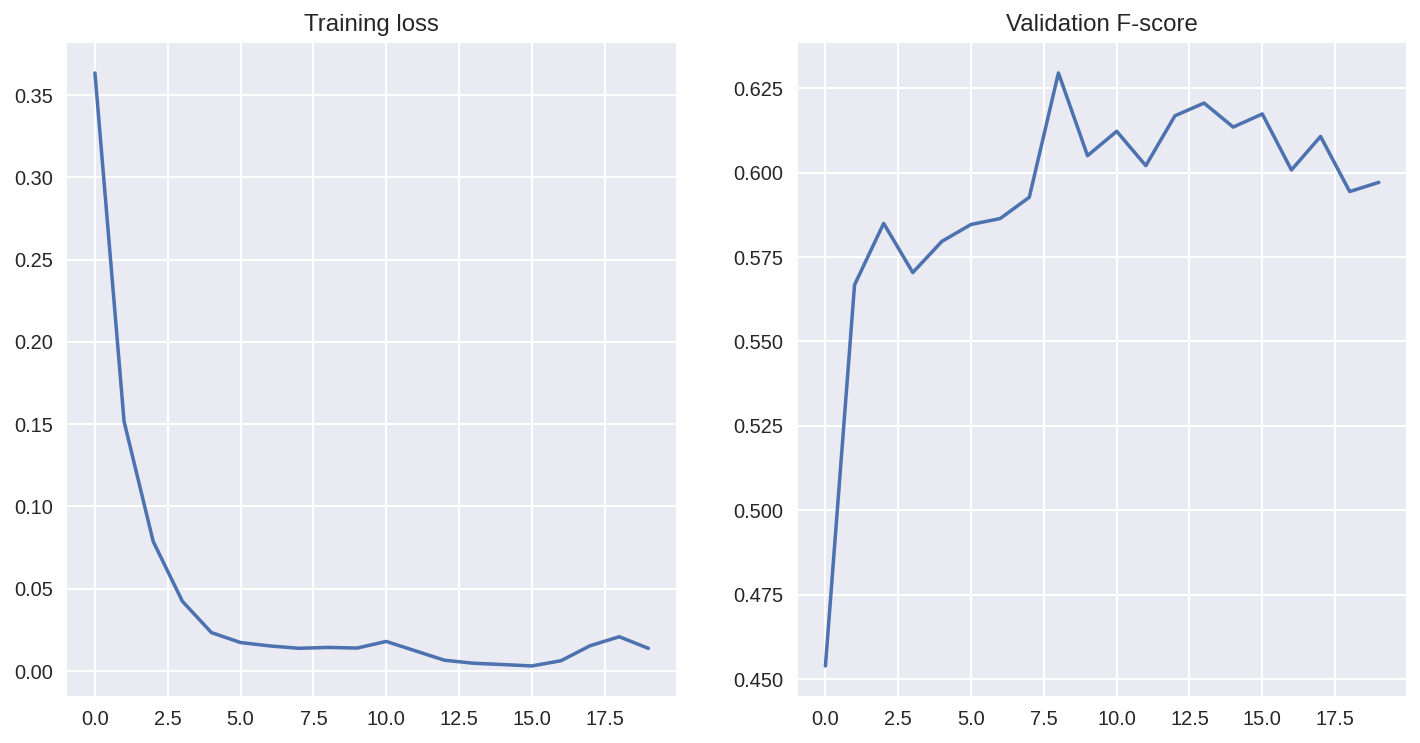

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system.history['val_f1']);
ax[1].set_title('Validation F-score')

Predicting outputs:

In [ ]:
ner_system.predict(['The patient suffered from bubonic plague and COVID-19 .'.split()])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [ ]:
ner_util.show_entities(ner_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

In [ ]:
ind = 14
token = Xval[ind]
print(ner_system.predict([token]))
(ner_util.show_entities(ner_system, [token]))
print(Yval[ind])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


['O', 'O', 'O', 'O', 'B-Chemical', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'O', 'B-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


##Helper function to run training loop several times and take mean of f1


In [ ]:
def train_n_times(system, n):
  f1_sum = 0
  for i in range(n): 
    tmp_f1 = system.fit(Xtrain, Ytrain, Xval, Yval)
    print()
    f1_sum += tmp_f1

  return f1_sum / n

In [ ]:
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)
f1_score = train_n_times(ner_system, 5)
print(f"Score before fine tuning word embedding: {f1_score}")

Epoch 1: train loss = 0.3634, val f1: 0.4538, time = 0.9663
Epoch 2: train loss = 0.1516, val f1: 0.5668, time = 0.9429
Epoch 3: train loss = 0.0787, val f1: 0.5850, time = 0.9732
Epoch 4: train loss = 0.0423, val f1: 0.5704, time = 0.9651
Epoch 5: train loss = 0.0233, val f1: 0.5797, time = 0.9653
Epoch 6: train loss = 0.0172, val f1: 0.5847, time = 0.9584
Epoch 7: train loss = 0.0152, val f1: 0.5864, time = 0.9426
Epoch 8: train loss = 0.0137, val f1: 0.5927, time = 0.9791
Epoch 9: train loss = 0.0143, val f1: 0.6296, time = 0.9563
Epoch 10: train loss = 0.0139, val f1: 0.6051, time = 0.9442
Epoch 11: train loss = 0.0179, val f1: 0.6123, time = 0.9204
Epoch 12: train loss = 0.0122, val f1: 0.6021, time = 0.9401
Epoch 13: train loss = 0.0065, val f1: 0.6169, time = 0.9431
Epoch 14: train loss = 0.0046, val f1: 0.6206, time = 0.9371
Epoch 15: train loss = 0.0039, val f1: 0.6135, time = 0.9386
Epoch 16: train loss = 0.0030, val f1: 0.6174, time = 0.9256
Epoch 17: train loss = 0.0062, va

Without tuning around 65%

With tuning around 71%

In [ ]:
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)
f1_score = train_n_times(ner_system, 5)
print(f"Score after fine tuning word embeddings: {f1_score}")

Epoch 1: train loss = 0.3282, val f1: 0.5458, time = 1.0439
Epoch 2: train loss = 0.1004, val f1: 0.6566, time = 1.0018
Epoch 3: train loss = 0.0363, val f1: 0.6559, time = 0.9982
Epoch 4: train loss = 0.0146, val f1: 0.6777, time = 0.9681
Epoch 5: train loss = 0.0059, val f1: 0.6801, time = 0.9851
Epoch 6: train loss = 0.0032, val f1: 0.6846, time = 0.9571
Epoch 7: train loss = 0.0014, val f1: 0.6899, time = 0.9829
Epoch 8: train loss = 0.0006, val f1: 0.6896, time = 0.9629
Epoch 9: train loss = 0.0007, val f1: 0.6856, time = 1.0003
Epoch 10: train loss = 0.0011, val f1: 0.6836, time = 0.9676
Epoch 11: train loss = 0.0024, val f1: 0.6825, time = 0.9786
Epoch 12: train loss = 0.0102, val f1: 0.6581, time = 0.9703
Epoch 13: train loss = 0.0163, val f1: 0.6716, time = 0.9706
Epoch 14: train loss = 0.0088, val f1: 0.6800, time = 0.9880
Epoch 15: train loss = 0.0049, val f1: 0.6858, time = 0.9769
Epoch 16: train loss = 0.0017, val f1: 0.6980, time = 0.9832
Epoch 17: train loss = 0.0004, va

## Using GloVe pretrained embeddings
the same as above, mean over 5 runs

77.5% without fine-tuning \\
77.8% with fine-tuning

In [ ]:
class NERParameters2:

    # Random seed, for reproducibility.
    random_seed = 1234
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128

    # Add som GRU params
    hidden_size = 50
    n_layers = 2
    batch_first = True
    bidirectional = True
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False

In [ ]:
import torch
from torch import nn

class RNNGloVeSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.        
                                                                   
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb)
        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]

        #input
        self.rnn = nn.LSTM(input_size = word_emb_dim, hidden_size = p.hidden_size, num_layers = p.n_layers,
                          batch_first = p.batch_first, dropout = p.word_dropout_prob, bidirectional = p.bidirectional)
        
        # Output unit.
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
                        
    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)      
        batch_size, max_sen_length = words.shape  

        # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim). 
        word_repr = self.word_embedding(words)
        #print(word_repr.shape)
        #print(words.shape)
        out, hidden = self.rnn(word_repr)
        #print(out.shape)
        #out = out.contiguous().view(-1, hidden.shape[-1])
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(out)    

In [ ]:
embedding = ner_util.load_gensim_vectors(model_file='glove-wiki-gigaword-100', builtin=True)


Loading model 'glove-wiki-gigaword-100' via gensim... done!


In [ ]:
new_system = ner_util.SequenceLabeler(NERParameters2(), RNNGloVeSequenceModel, pretrained_word_emb=embedding)
#print(new_sys)
f1_score_pretrained = train_n_times(new_system, 5)
print(f1_score_pretrained)

Epoch 1: train loss = 0.3398, val f1: 0.6612, time = 0.9701
Epoch 2: train loss = 0.1422, val f1: 0.7213, time = 0.9480
Epoch 3: train loss = 0.1051, val f1: 0.7279, time = 0.9522
Epoch 4: train loss = 0.0847, val f1: 0.7490, time = 0.9473
Epoch 5: train loss = 0.0665, val f1: 0.7555, time = 0.9834
Epoch 6: train loss = 0.0522, val f1: 0.7594, time = 0.9706
Epoch 7: train loss = 0.0424, val f1: 0.7673, time = 0.9283
Epoch 8: train loss = 0.0336, val f1: 0.7623, time = 0.9401
Epoch 9: train loss = 0.0268, val f1: 0.7656, time = 0.9302
Epoch 10: train loss = 0.0333, val f1: 0.7558, time = 0.9436
Epoch 11: train loss = 0.0210, val f1: 0.7661, time = 0.9395
Epoch 12: train loss = 0.0149, val f1: 0.7696, time = 0.9648
Epoch 13: train loss = 0.0109, val f1: 0.7754, time = 0.9486
Epoch 14: train loss = 0.0130, val f1: 0.7676, time = 0.9253
Epoch 15: train loss = 0.0112, val f1: 0.7726, time = 0.9504
Epoch 16: train loss = 0.0057, val f1: 0.7689, time = 0.9461
Epoch 17: train loss = 0.0036, va

In [ ]:
ner_util.show_entities(new_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

## Domain specific word embedding

using a smaller version of the embeddings

without fine-tuning: 84.1% \\
with fine-tuning: 82.4%

Seems to get worse with fine-tuning. Maybe the fine-tuning is redundant when using pre-trained embeddings and only necessary for the non pre-trained embeddings. 

In [ ]:
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/PubMed-and-PMC-w2v-500000.bin

--2022-12-09 15:03:01--  http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/PubMed-and-PMC-w2v-500000.bin
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404737271 (386M) [application/octet-stream]
Saving to: ‘PubMed-and-PMC-w2v-500000.bin’

000.bin              72%[=============>      ] 279.73M  12.6KB/s    eta 5m 55s ^C


In [ ]:
domain_embedding = ner_util.load_gensim_vectors(model_file='PubMed-and-PMC-w2v-500000.bin', builtin=False)

Loading model 'PubMed-and-PMC-w2v-500000.bin' via gensim...

ValueError: ignored

In [ ]:
class NERParameters3:

    # Random seed, for reproducibility.
    random_seed = 1234
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128

    # Add som GRU params
    hidden_size = 100
    n_layers = 2
    batch_first = True
    bidirectional = True
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False

In [ ]:
import torch
from torch import nn

class RNNDomainSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.        
                                                                   
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb)
        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]

        #input
        self.rnn = nn.GRU(input_size = word_emb_dim, hidden_size = p.hidden_size, num_layers = p.n_layers,
                          batch_first = p.batch_first, dropout = p.word_dropout_prob, bidirectional = p.bidirectional)
        
        # Output unit.
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
                        
    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)      
        batch_size, max_sen_length = words.shape  
        # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim). 
        word_repr = self.word_embedding(words)
        #print(word_repr.shape)
        #print(words.shape)
        out, hidden = self.rnn(word_repr)
        #print(out.shape)
        #out = out.contiguous().view(-1, hidden.shape[-1])
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(out)    

In [ ]:
domain_system = ner_util.SequenceLabeler(NERParameters3(), RNNDomainSequenceModel, pretrained_word_emb=domain_embedding)
f1_score_pretrained_domain = train_n_times(domain_system, 5)
print(f1_score_pretrained_domain)

In [ ]:
ner_util.show_entities(domain_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

In [ ]:
ind = 0
token = Xval[ind]
print(domain_system.predict([token]))
(ner_util.show_entities(domain_system, [token]))
print(Yval[ind])

## TASK 3: using character based word representations

Not implemented anything here yet

In [ ]:
class NERParameters4:

    # Random seed, for reproducibility.
    random_seed = 1234
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128

    # Add som GRU params
    hidden_size = 100
    n_layers = 2
    batch_first = True
    bidirectional = True
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = True

In [ ]:
import torch
from torch import nn

class RNNCharSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.        
                                                                   
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb)
        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]
        print(len(seq_labeler.word_voc.stoi))
        #input
        self.rnn = nn.GRU(input_size = word_emb_dim, hidden_size = p.hidden_size, num_layers = p.n_layers,
                          batch_first = p.batch_first, dropout = p.word_dropout_prob, bidirectional = p.bidirectional)
        
        # Output unit.
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
                        
    def forward(self, words, chars):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)      
        #batch_size, max_sen_length = words.shape 

        batch_size, max_sen_length, max_word_length = chars.shape
        chars_reshaped = torch.reshape(chars, (batch_size, max_sen_length*max_word_length))
        #print(chars_reshaped.shape) 
        # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim). 
        word_repr = self.word_embedding(words)
        #print(word_repr.shape)
        #print(words.shape)
        out, hidden = self.rnn(word_repr)
        #print(out.shape)
        #out = out.contiguous().view(-1, hidden.shape[-1])
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(out)    

In [ ]:
char_system = ner_util.SequenceLabeler(NERParameters4(), RNNCharSequenceModel, pretrained_word_emb=domain_embedding)
f1_score_char = train_n_times(char_system, 5)


## TASK 4 using BERT
The regular BERT: 85.1% \\
The domain specific BERT: 89.6%

In [ ]:
class NERParameters5:

    # Random seed, for reproducibility.
    random_seed = 1234
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128

    # Add som GRU params
    hidden_size = 100
    n_layers = 2
    batch_first = True
    bidirectional = True
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.00005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.1
        
    # Set the following to True to enable character tensors.
    use_characters = False

    # For BERT use
    bert_max_len = 100
    bert_model_name = 'distilbert-base-uncased'

Load tokenizer

In [ ]:
from transformers import AutoTokenizer
model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Load model

In [ ]:
from transformers import AutoModel
bert_model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_input = tokenizer(['The sun is shining a lot.'], return_tensors='pt')
test_input.input_ids.shape

torch.Size([1, 9])

In [ ]:
import torch
from torch import nn

class BERTSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()
        
        p = seq_labeler.params
        print('Loading pre-trained model...')
        self.bert_model = AutoModel.from_pretrained(p.bert_model_name)

        #self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb)
        
        # Size of the pre-trained model's word representations.
        hidden_size = self.bert_model.config.hidden_size

        # Number of classes for the classification task.
        nbr_classes = seq_labeler.n_labels
    
        # Also don't forget to create a classification "head" (output unit).
        self.top_layer = nn.Linear(hidden_size, nbr_classes)
  

    def forward(self, words):
        #batch_size, max_sen_length = x.shape

        #tokens = tokenizer(words)
        
        #input_id = tokens.input_ids
        output_bert = self.bert_model(words)[0]
        out = self.top_layer(output_bert)

        
        # Xbatch is the document tensor of shape (n_docs, max_length), where
        # n_docs is the number of documents in the batch, and max_length is
        # the maximal document length in the batch. Since we truncate the
        # documents to length 128 in this example, max_length will be 128
        # in most cases.
        # Xmask is the attention mask: it is 0 for the positions corresponding to
        # the padding tokens, and 1 elsewhere.
            
        # Your code here...
        # As usual, print the shapes of the tensors if you are confused!
            
        # When you have implemented this, the output shape should be (n_docs, nbr_classes) 
        # as in our previous classifiers. This output contains the logits for the classes: 
        # you do not have to apply a softmax.
        return out

In [ ]:
 
bert_system = ner_util.SequenceLabeler(NERParameters5(), BERTSequenceModel, bert_tokenizer=tokenizer)
bert_system.fit(Xtrain, Ytrain, Xval, Yval)
#bert_system. 

Loading pre-trained model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 1: train loss = 0.3296, val f1: 0.7572, time = 45.6250
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 2: train loss = 0.1151, val f1: 0.7973, time = 44.0524
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
...................................

0.85145402148284

Show the training progress

Text(0.5, 1.0, 'Validation F-score')

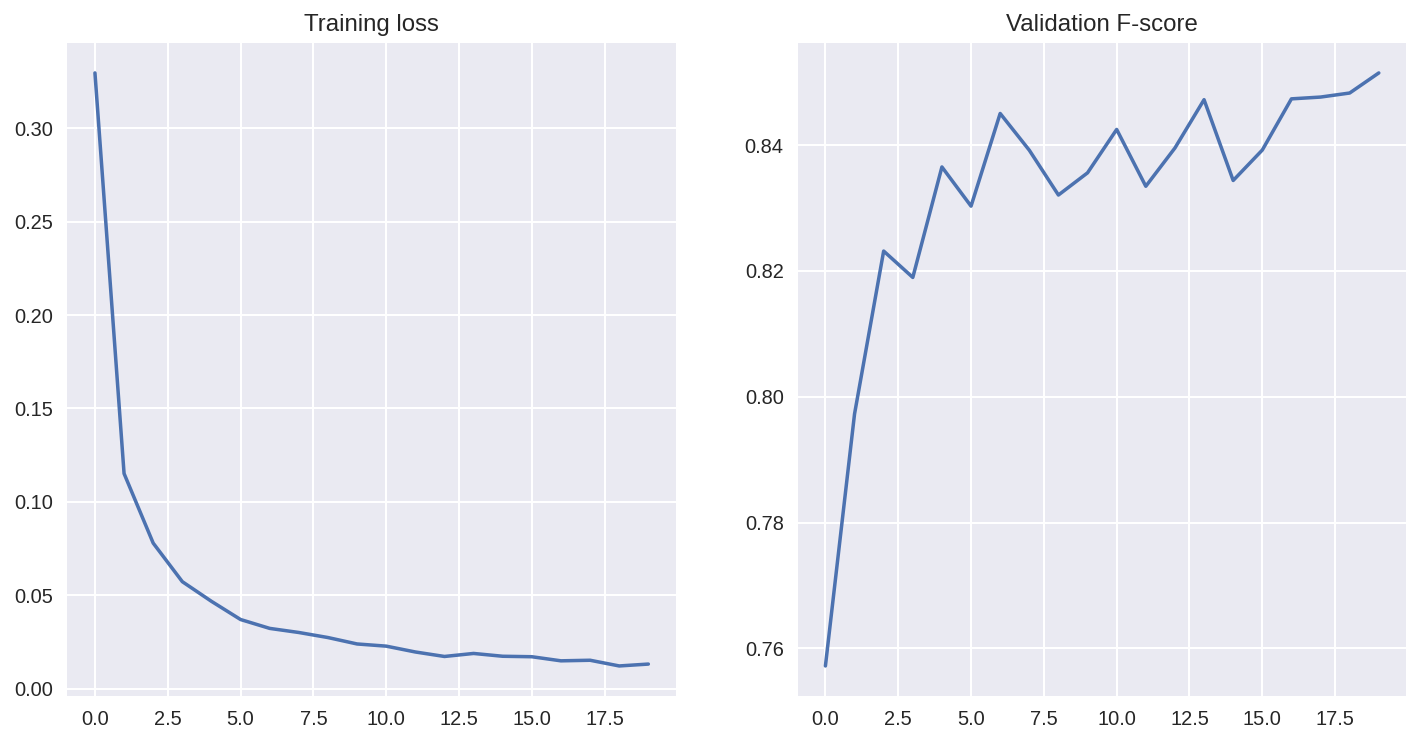

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(bert_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(bert_system.history['val_f1']);
ax[1].set_title('Validation F-score')

In [ ]:
ner_util.show_entities(bert_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

Test some sentences from validation

In [ ]:
ind = 0
token = Xval[ind]
print(bert_system.predict([token]))
(ner_util.show_entities(bert_system, [token]))
print(Yval[ind])

[['B-Chemical', 'I-Chemical', 'I-Chemical', 'I-Chemical', 'I-Chemical', 'I-Chemical', 'I-Chemical', 'I-Chemical', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'O']]


['B-Chemical', 'I-Chemical', 'I-Chemical', 'O', 'B-Disease', 'I-Disease', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'O']


Second part of task 4, we now try a domain specific pretrained BERT model

In [ ]:
class NERParameters6:

    # Random seed, for reproducibility.
    random_seed = 1234
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128

    # Add som GRU params
    hidden_size = 100
    n_layers = 2
    batch_first = True
    bidirectional = True
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 10
    batch_size = 32    
    learning_rate = 0.00005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.1
        
    # Set the following to True to enable character tensors.
    use_characters = False

    # For BERT use
    bert_max_len = 100
    bert_model_name = 'dmis-lab/biobert-v1.1'

In [ ]:
model_name = 'dmis-lab/biobert-v1.1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
bert_domain_system = ner_util.SequenceLabeler(NERParameters6(), BERTSequenceModel, bert_tokenizer=tokenizer)
bert_domain_system.fit(Xtrain, Ytrain, Xval, Yval)

Loading pre-trained model...


Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 1: train loss = 0.5094, val f1: 0.8331, time = 91.4859
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 2: train loss = 0.1187, val f1: 0.8654, time = 92.4324
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
...................................

0.8909534437120465

Text(0.5, 1.0, 'Validation F-score')

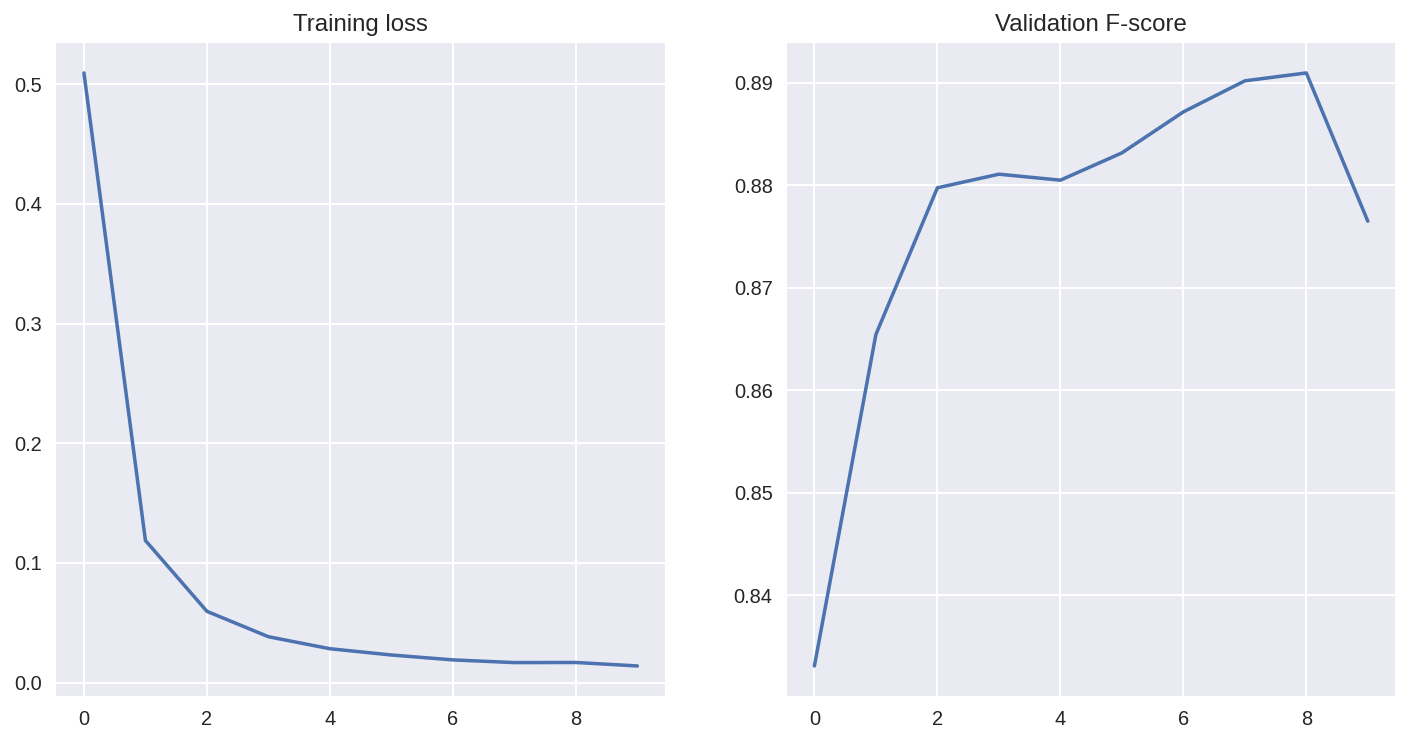

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(bert_domain_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(bert_domain_system.history['val_f1']);
ax[1].set_title('Validation F-score')

In [ ]:
ner_util.show_entities(bert_domain_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

In [ ]:
ind = 105
token = Xval[ind]
print(bert_domain_system.predict([token]))
(ner_util.show_entities(bert_domain_system, [token]))

print(Yval[ind])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Chemical', 'I-Chemical', 'I-Chemical', 'O', 'B-Chemical', 'O', 'O', 'O', 'O', 'B-Disease', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'O']]


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Chemical', 'I-Chemical', 'O', 'B-Chemical', 'O', 'O', 'O', 'O', 'B-Disease', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O']


## Summary of results
RNN model without fine-tuning: 65% \\
RNN model with fine-tuning: 71% \\

RNN model with pretrained word embeddings without fine-tuning: 77.5% \\
RNN model with pretrained word embeddings with fine-tuning: 77.8% \\

RNN model with pretrained domain specifc word embeddings without fine-tuning: 84.1% \\
RNN model with pretrained domain specifc word embeddings fine-tuning: 82.4% \\

BERT non domain specific model: 85.1% \\
BERT domain specific model: 89.6%

## CONCLUSIONS
The resulst of the domain specific BERT is the better option which seem reasonable. Using a system pretrained on articles with connections to the data set at hand should yield a better result. However, a more general model is less limited since it's not possible to use across different domain.

By looking at some examples the systems mostly tags the sentences correctly but the output for the BERT systems is a bit weird and therefore, quite hard to examine. It's easier to read the entity output for the RNN models and by just looking at sentences the RNN models with pretrained word embeddings seem to work as good as the BERT models. The BERT models gets a bit better F1-score, 89% against 84%, but since the result are that close it's quite hard som distinguish the differences by looking at some tagged sentences.